In [1]:
from google.colab import drive
drive.mount(
    '/content/drive'
)

%cd drive/Shareddrives/CS682Project/

Mounted at /content/drive
/content/drive/Shareddrives/CS682Project


In [2]:
import torchvision as tv
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 0, 'pin_memory': True} if device=='cuda' else {}

# Importing Models and Data

Start by pulling public, pretrained models for MobileNetV2 and V3, and EfficientNet



In [ ]:
mobilev2 = tv.models.mobilenet_v2(pretrained=True,progress=True)
print(mobilev2)

In [ ]:
mobilev3 = tv.models.mobilenet_v3_large(pretrained=True,progress=True)
mobilev3.eval()

In [ ]:
# effNet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# effNet.eval()

In [7]:
transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((160,160))
])

TRAIN_DIR = 'data/training'
TEST_DIR  = 'data/testing'
train_dataset = tv.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
val_test = tv.datasets.ImageFolder(root=TEST_DIR, transform=transform)
val_size = len(val_test) // 5

val_dataset, test_dataset = random_split(val_test, [val_size, len(val_test) - val_size])

classes = train_dataset.class_to_idx

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


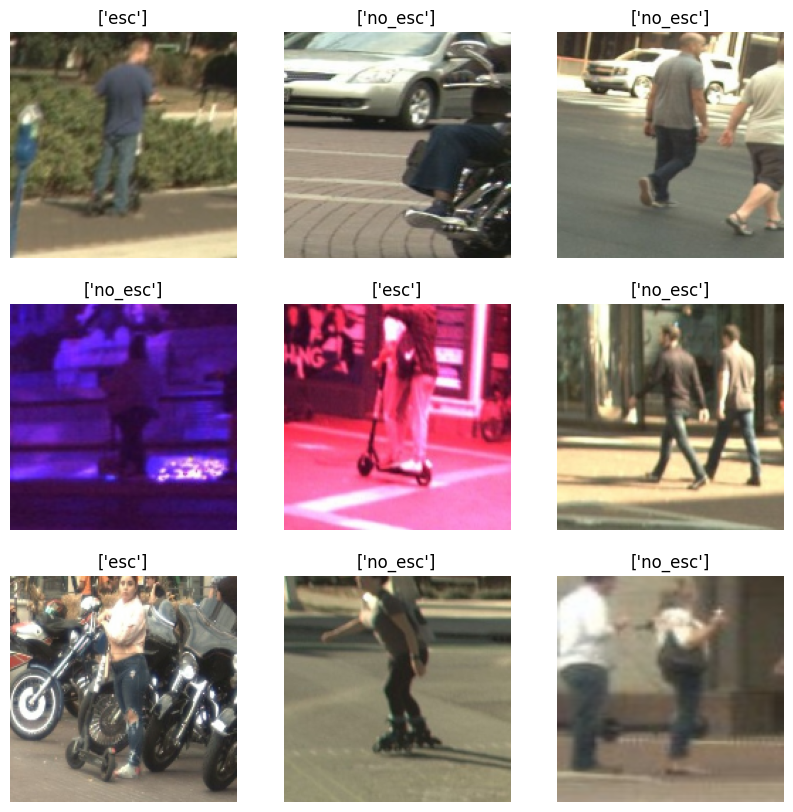

In [8]:
training = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=None, **kwargs)
tr_images_batch, tr_labels_batch = next(iter(training))

val = DataLoader(val_dataset, batch_size=32, shuffle=True, **kwargs)
test = DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.transpose(tr_images_batch[i], (1,2,0)))
  plt.title([str(x) for x in classes if classes[x] == tr_labels_batch[i]])
  plt.axis("off")

# Add Fully-connected Layer for Fine-tuning

Now we add an nn.Linear layer to each model, to be trained on our dataset as a fine-tuning step

In [ ]:

# mobilev3.classifier[-1] = torch.nn.Linear(1280,2)

In [11]:
# Duplicate our previous model, removing the classification layer to perform feature extraction
mobilev2_feat_extract = torch.nn.Sequential(*list(mobilev2.children())[:-1])

In [12]:
feature_batch = mobilev2_feat_extract(tr_images_batch)
print(feature_batch.shape)

global_average_layer = torch.nn.AdaptiveAvgPool2d((1,1))
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

torch.Size([32, 1280, 5, 5])
torch.Size([32, 1280, 1, 1])


In [13]:
prediction_layer = torch.nn.Linear(1280, 1)
act = torch.nn.Sigmoid()

# Flatten feature batch
flattened = torch.flatten(feature_batch_average, 1)

pred_batch = prediction_layer(flattened)
pred_batch = act(pred_batch)
print(pred_batch.shape)

torch.Size([32, 1])


In [14]:
# Prepare model for fine-tuning
for param in mobilev2.parameters():
  param.requires_grad = False
mobilev2.classifier[-1] = torch.nn.Linear(1280,2)
mobilev2.features.append(global_average_layer)
print(mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
# Inspiration from Assignment 2 Implementation
def train_model(model, optimizer, epochs=1):
  model.to(device)
  for e in range(epochs):
    for t, (x, y) in enumerate(training):
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % 100 == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        num_correct = 0
        num_samples = 0
        with torch.no_grad():
          for x, y in val:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
          acc = float(num_correct) / num_samples
          print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print()

In [16]:
optimizer = optim.Adam(mobilev2.parameters(), lr = 0.0001, weight_decay=1e-5)
train_model(mobilev2, optimizer, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Iteration 0, loss = 0.7162
Got 272 / 499 correct (54.51)

Iteration 100, loss = 0.6008
Got 353 / 499 correct (70.74)



KeyboardInterrupt: ignored

In [ ]:
mobilev3.eval()